In [1]:
import featuretools as ft
from featuretools.primitives import Percentile
import composeml as cp
import pandas as pd

# Load in data

In [2]:
cyber_df = pd.read_csv("data/CyberFLTenDays.csv").sample(10000)
cyber_df.index.name = "log_id"
cyber_df.reset_index(inplace=True, drop=False)
cyber_df['label'] = cyber_df['label'].map({'N': False, 'A': True}, na_action='ignore')

# Create an EntitySet with many different dataframes

Each dataframe is a different definition of "connection"

In [3]:
es = ft.EntitySet("CyberLL")
# create an index column
cyber_df["name_host_pair"] = cyber_df["src_name"].str.cat(
                                [cyber_df["dest_name"],
                                 cyber_df["src_host"],
                                 cyber_df["dest_host"]],
                                sep=' / ')
cyber_df["src_pair"] = cyber_df["src_name"].str.cat(
                                 cyber_df["src_host"],
                                 sep=' / ')
cyber_df["dest_pair"] = cyber_df["dest_name"].str.cat(
                                 cyber_df["dest_host"],
                                 sep=' / ')
es.add_dataframe(dataframe_name="log",
                 dataframe=cyber_df,
                 index="log_id",
                 time_index="secs")
es.normalize_dataframe(base_dataframe_name="log",
                       new_dataframe_name="name_host_pairs",
                       index="name_host_pair",
                       additional_columns=["src_name", "dest_name",
                                           "src_host", "dest_host",
                                           "src_pair",
                                           "dest_pair",
                                           "label"])
es.normalize_dataframe(base_dataframe_name="name_host_pairs",
                       new_dataframe_name="src_pairs",
                       index="src_pair",
                       additional_columns=["src_name", "src_host"])
es.normalize_dataframe(base_dataframe_name="src_pairs",
                       new_dataframe_name="src_names",
                       index="src_name")
es.normalize_dataframe(base_dataframe_name="src_pairs",
                       new_dataframe_name="src_hosts",
                       index="src_host")
es.normalize_dataframe(base_dataframe_name="name_host_pairs",
                       new_dataframe_name="dest_pairs",
                       index="dest_pair",
                       additional_columns=["dest_name", "dest_host"])
es.normalize_dataframe(base_dataframe_name="dest_pairs",
                       new_dataframe_name="dest_names",
                       index="dest_name")
es.normalize_dataframe(base_dataframe_name="dest_pairs",
                       new_dataframe_name="dest_hosts",
                       index="dest_host")

Entityset: CyberLL
  DataFrames:
    log [Rows: 10000, Columns: 7]
    name_host_pairs [Rows: 8001, Columns: 5]
    src_pairs [Rows: 7325, Columns: 4]
    src_names [Rows: 5701, Columns: 2]
    src_hosts [Rows: 3467, Columns: 2]
    dest_pairs [Rows: 7370, Columns: 4]
    dest_names [Rows: 5728, Columns: 2]
    dest_hosts [Rows: 922, Columns: 2]
  Relationships:
    log.name_host_pair -> name_host_pairs.name_host_pair
    name_host_pairs.src_pair -> src_pairs.src_pair
    src_pairs.src_name -> src_names.src_name
    src_pairs.src_host -> src_hosts.src_host
    name_host_pairs.dest_pair -> dest_pairs.dest_pair
    dest_pairs.dest_name -> dest_names.dest_name
    dest_pairs.dest_host -> dest_hosts.dest_host

## Visualize EntitySet

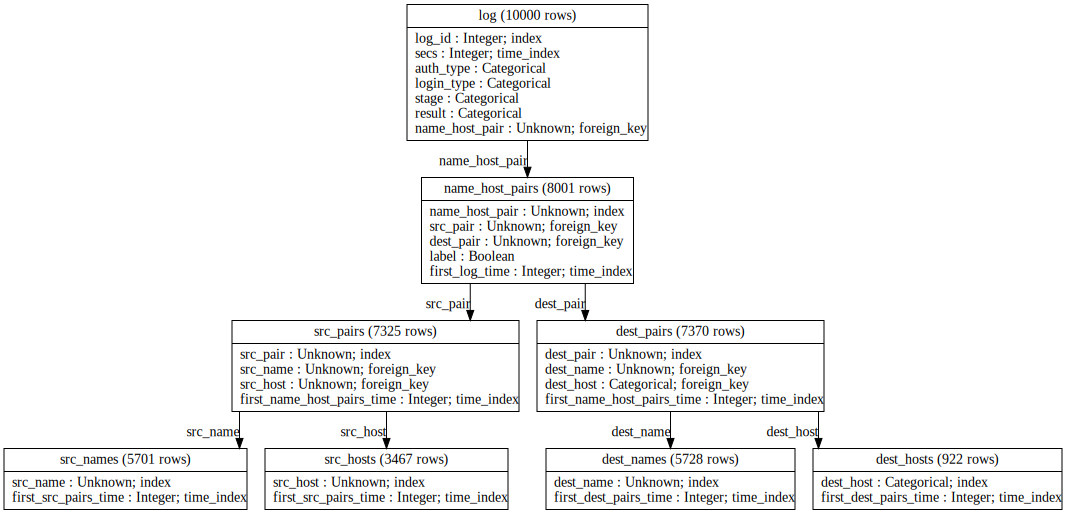

In [4]:
es.plot()

# Define function to generate labels and cutoff times

We use [Compose](https://compose.featurelabs.com/) to define our labeling function.

In [5]:
def malicious_connection(df, lead):
    if (len(df.index) > lead + 1): 
        return df.iloc[lead:]['label'].any()
    
def label_generator(cyber_df, index_col, after_n_obs, lead, prediction_window):
    lm = cp.LabelMaker(
        target_dataframe_name=index_col,
        time_index="secs",
        labeling_function=malicious_connection,
        window_size=window + lead
    )
    label_times = lm.search(
        cyber_df.sort_values('secs'),
        minimum_data=after_n_obs,
        gap=after_n_obs + lead + window,
        num_examples_per_instance=1,
        lead=lead,
        verbose=False
    )
    label_times['time'] = pd.to_numeric(label_times['time'])
    return label_times

In [6]:
# predict after 3 observations
after_n_obs = 3

# predict 2 observations out
lead = 2

# predict if any malicious attacks in a 10-observation window
window = 10

# Compute features for various types of connections

In [7]:
# features on src_name
cutoffs = label_generator(cyber_df, "src_name", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="src_names", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 799 features
Elapsed: 01:20 | Progress: 100%|██████████████████████████████████████████


In [8]:
## features on src_host
cutoffs = label_generator(cyber_df, "src_host", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="src_hosts", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 799 features
Elapsed: 01:17 | Progress: 100%|██████████████████████████████████████████


In [9]:
## features on dest_name
cutoffs = label_generator(cyber_df, "dest_name", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="dest_names", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 793 features
Elapsed: 01:24 | Progress: 100%|██████████████████████████████████████████


In [10]:
## features on dest_host
cutoffs = label_generator(cyber_df, "dest_host", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="dest_hosts", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 799 features
Elapsed: 01:00 | Progress: 100%|██████████████████████████████████████████


In [11]:
# features on src_name/dest_name/src_host/dest_host
cutoffs = label_generator(cyber_df, "name_host_pair", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="name_host_pairs", cutoff_time=cutoffs, verbose=True, max_depth=2, trans_primitives=[Percentile])

Built 88 features
Elapsed: 01:19 | Progress: 100%|██████████████████████████████████████████


In [12]:
# merge entities together to access the index variables created in the process of normalizing
merged = (es['log'].merge(es['name_host_pairs'])
                   .merge(es['src_pairs'])
                   .merge(es['dest_pairs']))

In [13]:
# features on src_name/src_host
cutoffs = label_generator(merged, 'src_pair', after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="src_pairs", cutoff_time=cutoffs, verbose=True, max_depth=2, trans_primitives=[Percentile])

Built 192 features
Elapsed: 00:59 | Progress: 100%|██████████████████████████████████████████


In [14]:
# features on dest_name/dest_host
cutoffs = label_generator(merged, 'dest_pair', after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_dataframe_name="dest_pairs", cutoff_time=cutoffs, verbose=True, max_depth=2, trans_primitives=[Percentile])

Built 193 features
Elapsed: 01:00 | Progress: 100%|██████████████████████████████████████████


## Built at Alteryx Innovation Labs

<p>
<a href="https://www.alteryx.com/innovation-labs">
    <img width="75%" src="https://evalml-web-images.s3.amazonaws.com/alteryx_innovation_labs.png" alt="Alteryx Innovation Labs" />
</a>
</p>